<a href="https://colab.research.google.com/github/wurDevTim/Workshop_P4P/blob/main/introduction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Welkom to the P4P workshop!
This notebook gives a few examples on how to analyze cropreporter data with plantcv.

There are also various tutorials on the plantcv website, unfortunately not all are updated to plantcv v4.0: https://plantcv.readthedocs.io/en/stable/tutorials/







# Preperation
For this training we prepared a small dataset you can download from:
https://drive.google.com/file/d/1i-EIXZ-hw4uwKRV40rPAql9Lb-eIDm1j/view?usp=sharing

Unzip the folder and upload the content to your own google drive.

In [1]:
# Plantcv only suports python version 3.8, 3.9 and 3.10.
# Colab only supports one python version, the current version is 3.10.12
import sys
print(f"Running python version: {sys.version}")

Running python version: 3.10.12 (main, Jun 11 2023, 05:26:28) [GCC 11.4.0]


Install the requirements

In [2]:
# plantcv requires a newer version of altair than installed by default
!pip install altair==5.0.1
!pip install plantcv

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.5/471.5 kB 5.6 MB/s eta 0:00:00
  Attempting uninstall: altair
    Found existing installation: altair 4.2.2
    Uninstalling altair-4.2.2:
      Successfully uninstalled altair-4.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires kaleido, which is not installed.
lida 0.0.10 requires python-multipart, which is not installed.
lida 0.0.10 requires uvicorn, which is not installed.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 327.9/327.9 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.3/47.3 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.0/27.0 MB 30.5 MB/s eta 0:00:00


In [3]:
# Mount google drive
from google.colab import drive
from os import path

datafolder = "/content/drive/My Drive/P4P_workshop_data"
# Check if the data folder is mounted correctly
if not path.exists(datafolder):
  drive.mount('/content/drive')

!ls "$datafolder"

Mounted at /content/drive
 cropreporter_traits.csv  'Enza Mandy Boon'   Lucia   Marie   npec_tomato   zheng


In [4]:
# Importing Libraries
from google.colab.patches import cv2_imshow
# Import packages
from plantcv import plantcv as pcv
from skimage.util import img_as_ubyte
import matplotlib.pyplot as plt
import numpy as np
import cv2

In [5]:
print(f"Currently installed plantcv version is v{pcv.__version__}")

Currently installed plantcv version is v4.0.1


# Plantcv
Plantcv implements quite some functions, in the notebook examples are gives of how to load the data and:
- Use the Chlorophyll image to create a mask
- Compute the spectral indices
- Compute the FV/FM
- Analyse an entire folder automatically
With two bonusses at the end

For more information see:
https://plantcv.readthedocs.io/en/stable/photosynthesis_read_cropreporter/

In [6]:
# Configure plantcv to show debug output
pcv.params.debug = "plot"
pcv.params.debug_outdir = "temp_output"
outdir = 'temp_output'

# Plantcv photosynthesis object
To start using plantcv for analysis of cropreporter data the following function can be called with the `.inf` file:

```
pcv.photosynthesis.read_cropreporter
```
The function automatically checks the folder for other cropreporter files like the SPC, PML, PMD, CHL and CLR file.

The function returns a PSII_data instance, which contains a subclass per data object:
*   ojip_light
*   ojip_dark
*   pam_light
*   pam_dark
*   chlorophyll
*   spectral

The RGB data is collected with the same monochrome camera as the spectral data, the only difference is the filter that is used: a Red, green or Blue filter.
It can be accessed with: `ps.spectral.pseudo_rgb`.
If a parameter was not measured the class is set to `None`.

Compiling: PMD
Compiling: CHL
Compiling: CLR
Compiling: SPC


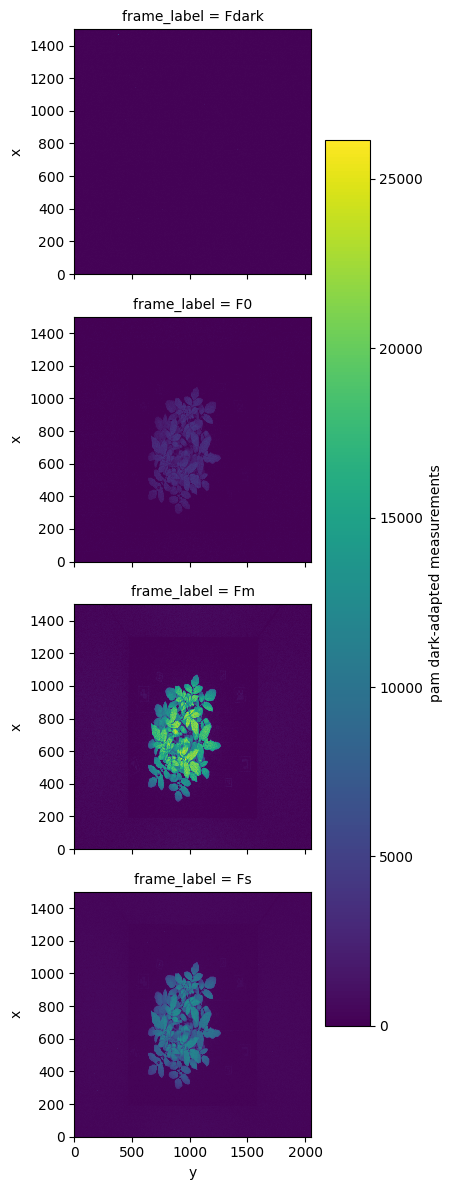

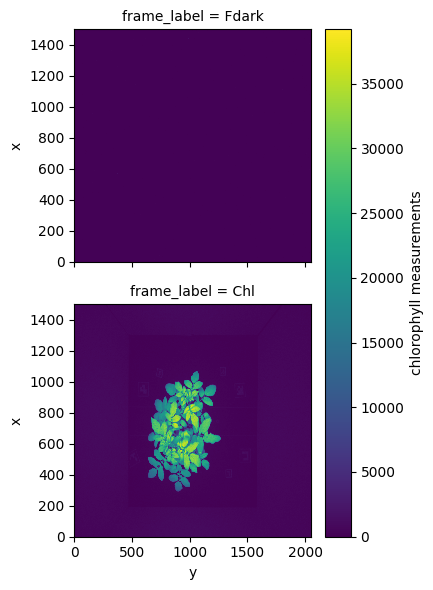

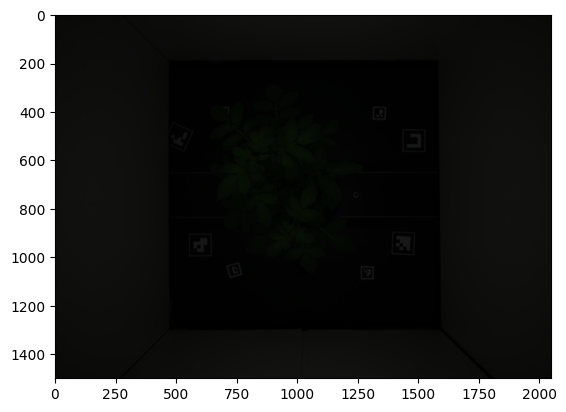

In [32]:
# Load the first dataset into plantcv

# Note this dataset does not contain photosynthesis (PAM) data
#filename = datafolder + "/20231018_AO1/HDR_96_NPEC51.20230906.AO1.MoneyMaker.Salt.88_1476.INF"

# Note: This dataset does not contain spectral(SPC) data
#filename = datafolder + "/Enza Mandy Boon/ChiVMV/HDR_E0044P0206N0001.INF"

# Note: This dataset does not contain color or spectral (CLR or SPC) data
#filename = datafolder + "/Marie/NPEC51.20231124.AA12.CYCTF23_0002.CYC_23_Y_BT1E.6/CropReporter/181215797/data/HDR_100_NPEC51.20231124.AA12.CYCTF23_0002.CYC_23_Y_BT1E.6_1515.INF"

# Note: This dataset does not contain spectral(SPC) data
#filename = datafolder + "/zheng/resiatant materials_1/0hpi/HDR_Experiment20230802shangwu_B1_P27_U1_DIRXpY0_T_G_2023-08-09_23-01-23.INF"

# Contains most data types, therefore this is ideal to start with
filename = datafolder + "/Lucia/NPEC52.20230605.BD4.CE3027.Control.1/CropReporter/124326957/data/HDR_90_NPEC52.20230605.BD4.CE3027.Control.1_1368.INF"

# Load the data
ps = pcv.photosynthesis.read_cropreporter(filename=filename)

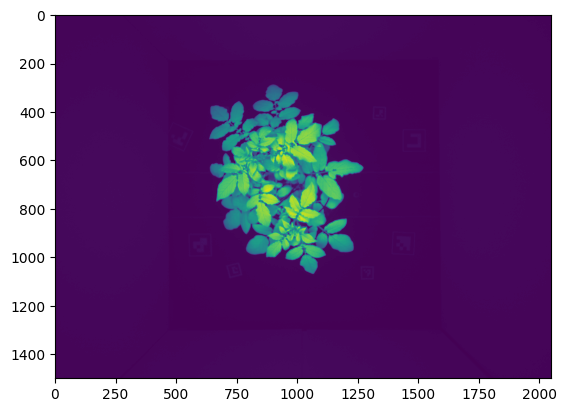

In [33]:
# Show the chlorophyll image
chlorophyll = ps.chlorophyll.sel(frame_label='Chl').to_numpy()
plt.imshow(chlorophyll)

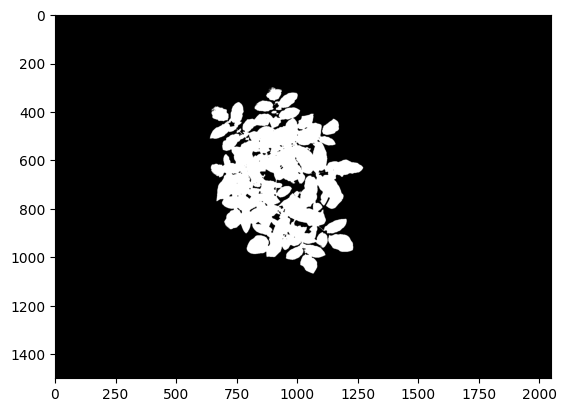

In [34]:
# Note the big difference between the plant and background.
# this makes the chlorophyll ideall to create masks
mask = pcv.threshold.otsu(gray_img=img_as_ubyte(ps.chlorophyll.sel(frame_label="Chl").data), object_type="light")
#mask = pcv.fill_holes(bin_img=mask)

In [10]:
# Compute average chlorophyll
chlorophyll = ps.chlorophyll.sel(frame_label='Chl').to_numpy()
masked_chlorophyll = cv2.bitwise_and(chlorophyll, chlorophyll, mask=mask)
mean_chlorophyll = np.nanmean(chlorophyll[mask > 0])
print(f"average chlorophyll: {round(mean_chlorophyll, 2)}")

average chlorophyll: 19045.59


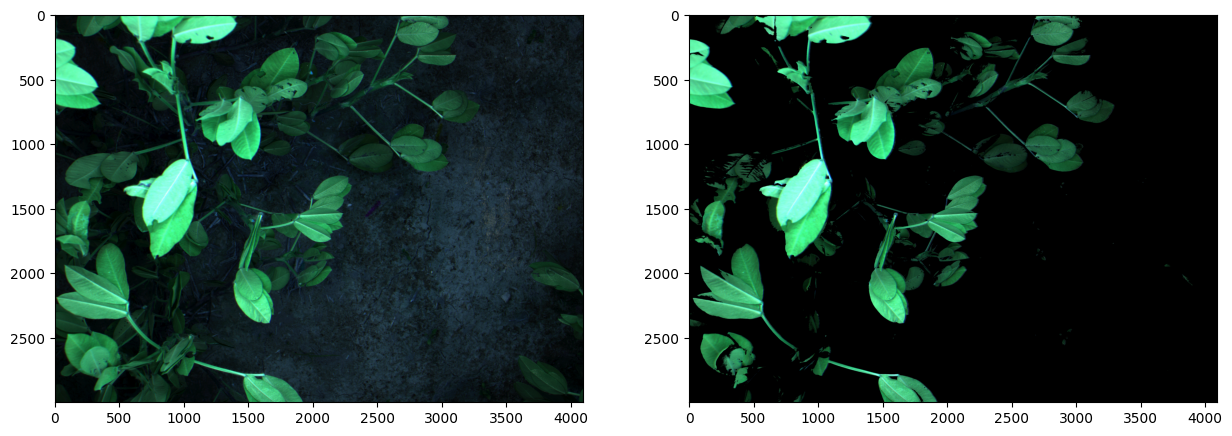

In [11]:
# Show the RGB image
img = ps.spectral.pseudo_rgb
img = cv2.bitwise_and(img, img, mask=mask)
# first parameter is the contrast scaling, the second the brightness, which is increased slightly for visualization
# For a concrete example see: https://www.tutorialspoint.com/how-to-change-the-contrast-and-brightness-of-an-image-using-opencv-in-python
img = cv2.convertScaleAbs(img, 1.0, 10)

f, axarr = plt.subplots(1,2, figsize=(15, 15))
axarr[0].imshow(cv2.convertScaleAbs(ps.spectral.pseudo_rgb, 1.0, 10))
axarr[1].imshow(img)
plt.show()
# Left the original image, Right the masked image

It is challenging to find a solution that scales to all plant species.
Here will show a few corrections which can be applied.

### Exercise
Try loading a different file by using one of the different filenames and play with the masking. Would you always use the chlorophyll image? Mask on the Photosynthesis data or use something else?

Below two examples are shown of how to improve the mask

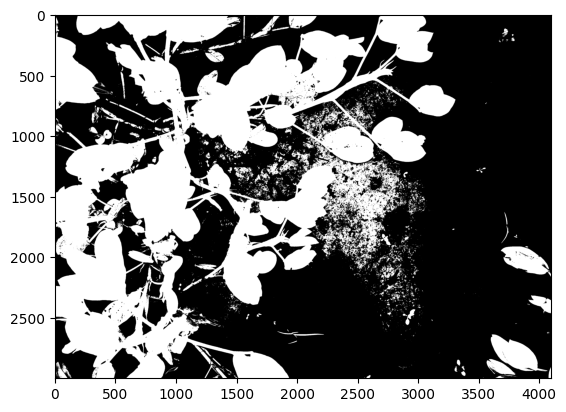

In [22]:
# Mask below chlorophyll value
threshold = 4000
chlorophyll = ps.chlorophyll.sel(frame_label='Chl').to_numpy()
threshold_mask = np.zeros(chlorophyll.shape, dtype=np.uint8)
idx = np.where(chlorophyll > threshold)
threshold_mask[idx] = 255
plt.imshow(threshold_mask, cmap='gray')

In [ ]:
# Fill small objects to remove noise and get a complete plant
# Inputs:
#   bin_img         - Binary image data
#   size            - Minimum object area size in pixels (integer), smaller objects get filled in.
filled_mask = pcv.fill(bin_img=mask, size=200)

In [ ]:
# Erode a small border of pixels from the mask
# Inputs:
#   gray_img - Grayscale (usually binary) image data
#   ksize - The size used to build a ksize x ksize
#            matrix using np.ones. Must be greater than 1 to have an effect
#   i - An integer for the number of iterations
eroded_mask = pcv.erode(gray_img=mask, ksize=3, i=1)

In [ ]:
unmasked_rgb = cv2.convertScaleAbs(ps.spectral.pseudo_rgb, 1.0, 10)
f, axarr = plt.subplots(1,2, figsize=(15, 15))
axarr[0].imshow(cv2.bitwise_and(unmasked_rgb, unmasked_rgb, mask=filled_mask))
axarr[1].imshow(cv2.bitwise_and(unmasked_rgb, unmasked_rgb, mask=eroded_mask))
plt.show()

In [ ]:
# One way to compare masks on similairy is to calculate the intersection over union.
# It returns values between 0-1, where 1 is identical and zero shows no overlap.
def calculate_iou(maska, maskb):
  maska = maska.flatten()
  maskb = maskb.flatten()
  mask = np.zeros_like(maska)
  mask[maska > 0] = 1
  mask_two = np.zeros_like(maskb)
  mask_two[maskb > 0] = 1

  overlap = mask * mask_two  # Logical AND
  union = (mask + mask_two)>0  # Logical OR
  iou = overlap.sum() / float(union.sum())
  return iou

print(f"Similairy of the original mask and filled mask: {round(calculate_iou(mask, filled_mask), 3)}, similairy of the erorded and original mask: {round(calculate_iou(mask, eroded_mask), 3)}")

# Spectral indices
Different pigments and chlorophyll content can be measured at different wavelengths, by combining these measurements the relation can be analyzed. As example, NDVI visualizes changes in the chlorophyl absorption of the plant.
A lower value indicates somethings is wrong with the plant, but it does not say anything about the cause.
It is also important to note that:
- Each camera uses slightly different settings/configurations which result in different NDVI values, making it challenging to compare or exactly reproduce experiments.
- Plants grow towards the camera, as they come closer there is less dispersion of light which is no problem when you fly a drone 30 meters above a potato field but introduces bias in measurement taken up-close, as done by the cropreporter.

There is an extensive list of spectral indexes available in plantcv, however not all can be computer with the wavelengths measured by the cropreporter:
https://github.com/danforthcenter/plantcv/blob/main/plantcv/plantcv/spectral_index/spectral_index.py

The indexes we show here are chosen based on this study:
[Application of Phenotyping Methods in Detection of Drought and Salinity Stress in Basil (Ocimum basilicum L.) (Boris et al. 2021)](https://www.frontiersin.org/articles/10.3389/fpls.2021.629441/full)
- NDVI
- ARI
- MARI
- PSRI
- Egreen

## Wavelengths
A few weeks ago, we discovered a small bug in the plantcv code, which is described here [cropreporter wavelengths](https://github.com/danforthcenter/plantcv/issues/1373)
This is fixed in the main branch, as there is no new release, we are currently using a plantcv version which contains this bug.

Currently the wavelengths are: {460, 500, 550, 670, 700, 800}
this be checked by running: `ps.spectral.wavelength_dict`

The wavelengths of the NPEC cropreporter are in reality: {475, 540, 550, 640, 710, 770}
Unfortunately, phenovation does not store this in their metadata so we cannot guaranty that this is the same for all systems sold worldwide.


In [35]:
# In the fix below we asume the dataset contains both a CLR and SPC file.
# Show the wavelengths
ps.spectral.wavelength_dict

{460: 0.0, 500: 1.0, 550: 2.0, 670: 3.0, 700: 4.0, 800: 5.0}

In [36]:
# Overwrite the dictionary with the correct wavelengths
ps.spectral.wavelength_dict = {475: 0.0, 540: 1.0, 550: 2.0, 640: 3.0, 710: 4.0, 770: 5.0}

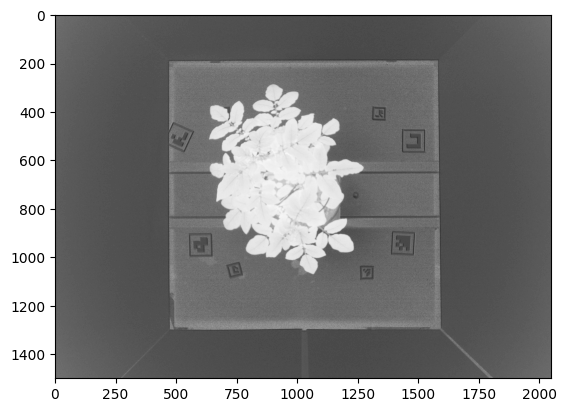

ndvi: 0.8225916028022766


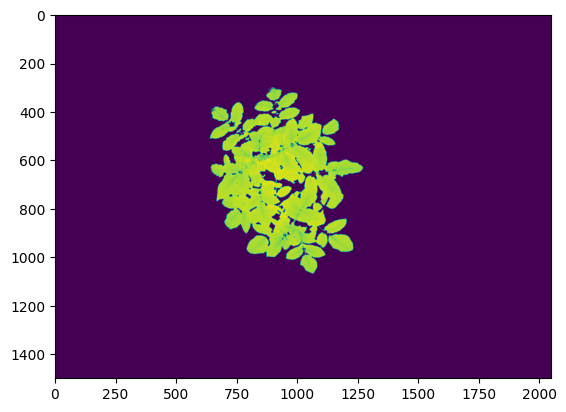

In [37]:
# Normalized Difference Vegetation Index: (R800 - R670) / (R800 + R670)
# The theoretical range for NDVI is [-1.0, 1.0]
ndvi_img = pcv.spectral_index.ndvi(hsi=ps.spectral, distance=30).array_data
masked_ndvi_img = cv2.bitwise_and(ndvi_img, ndvi_img, mask=mask)
mean_ndvi = np.nanmean(ndvi_img[mask > 0])
print(f"ndvi: {mean_ndvi}")
plt.imshow(masked_ndvi_img)

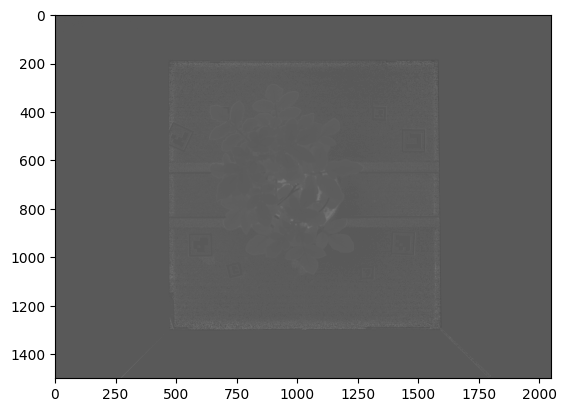

ari: 13.964815139770508


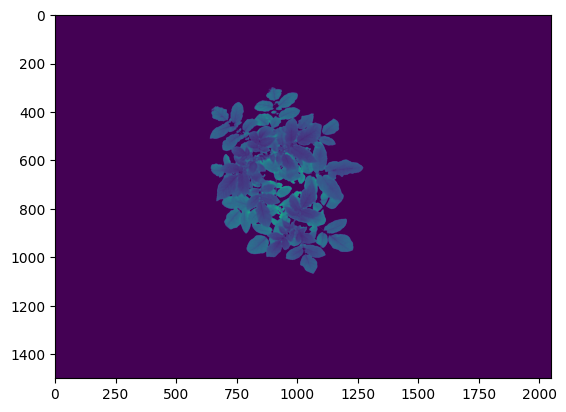

In [38]:
# Anthocyanin Reflectance Index: (1 / R550) - (1 / R700)
# The theoretical range for ARI is (-Inf, Inf)
ari_img = pcv.spectral_index.ari(hsi=ps.spectral).array_data
masked_ari_img = cv2.bitwise_and(ari_img, ari_img, mask=mask)
plt.imshow(masked_ari_img)
mean_ari = np.nanmean(ari_img[mask > 0])
print(f"ari: {mean_ari}")

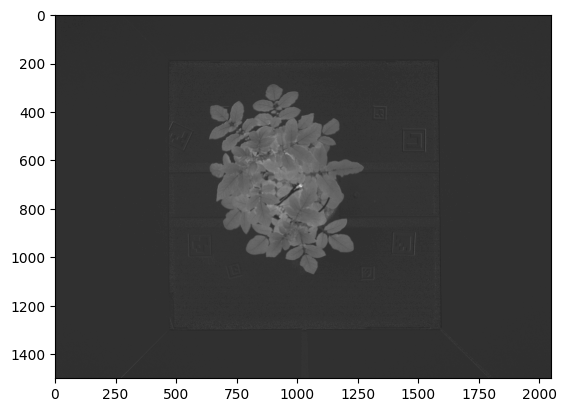

modified ari: 2.656475067138672


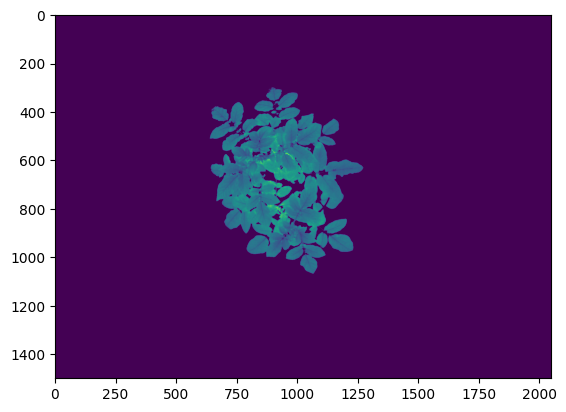

In [39]:
# Modified Anthocyanin Reflectance Index: ((1 / R550) - (1 / R700)) * R800
# The theoretical range for Modified ARI is (-Inf, Inf)
mari_img = pcv.spectral_index.mari(hsi=ps.spectral, distance=30).array_data
masked_mari_img = cv2.bitwise_and(mari_img, mari_img, mask=mask)
plt.imshow(masked_mari_img)
mean_mari = np.nanmean(mari_img[mask > 0])
print(f"modified ari: {mean_mari}")

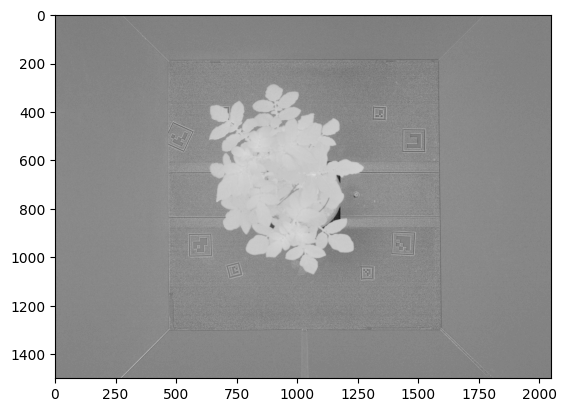

psri: 0.4469869136810303


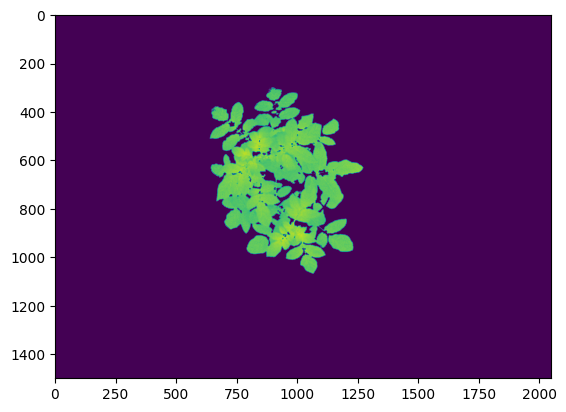

In [40]:
# Plant Senescence Reflectance Index: (R678 - R500) / R750
# The theoretical range for PSRI is (-Inf, Inf)
# An increase in PSRI sugest an increase in canopy stress.
psri_img = pcv.spectral_index.psri(hsi=ps.spectral).array_data
masked_psri_img = cv2.bitwise_and(psri_img, psri_img, mask=mask)
plt.imshow(masked_psri_img)
mean_psri = np.nanmean(psri_img[mask > 0])
print(f"psri: {mean_psri}")

/usr/local/lib/python3.10/dist-packages/plantcv/plantcv/spectral_index/spectral_index.py:270: RuntimeWarning: invalid value encountered in divide
  r = red.astype(np.float32) / total
/usr/local/lib/python3.10/dist-packages/plantcv/plantcv/spectral_index/spectral_index.py:271: RuntimeWarning: invalid value encountered in divide
  g = green.astype(np.float32) / total
/usr/local/lib/python3.10/dist-packages/plantcv/plantcv/spectral_index/spectral_index.py:272: RuntimeWarning: invalid value encountered in divide
  b = blue.astype(np.float32) / total


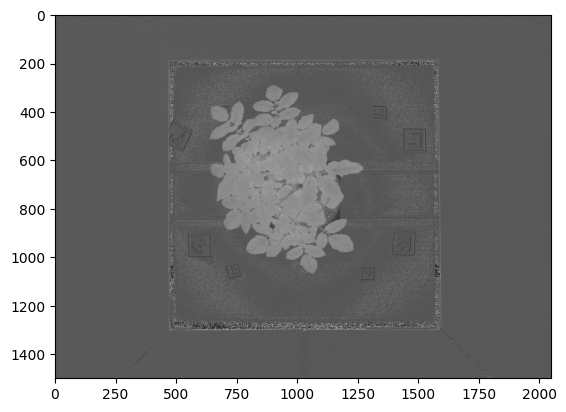

egreen: 0.6555136442184448


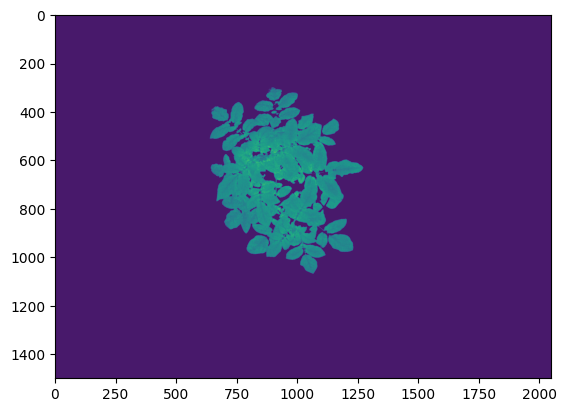

In [41]:
# Excess Green Index: 2g - r - b
# The theoretical range for EGI is (-1, 2)
# Question why do you see warnings?
egreen_img = pcv.spectral_index.egi(ps.spectral.pseudo_rgb).array_data
masked_egreen_img = cv2.bitwise_and(egreen_img, egreen_img, mask=mask)
plt.imshow(masked_egreen_img)
mean_egreen = np.nanmean(egreen_img[mask > 0])
print(f"egreen: {mean_egreen}")

# Which other indexes you think will be interesting to analyse? Why?
To give you a hint, our cropreporter meassures at the following wavelengths:
- [RGB wavelengths](https://github.com/danforthcenter/plantcv/blob/10a33cc8cdba9c7a5f8dda0637e4172cbf6681b5/plantcv/plantcv/photosynthesis/read_cropreporter.py#L282C9-L282C21)
- [Spectral wavelengths](https://github.com/danforthcenter/plantcv/blob/10a33cc8cdba9c7a5f8dda0637e4172cbf6681b5/plantcv/plantcv/photosynthesis/read_cropreporter.py#L289C14-L289C14)


#Photosynthesis analysis
Unfortunately, there is no consensus on how photosythesis measurement should be done or how to name the frames, as a result different terms are used in literature. For the cropreporter PAM measurements it is as follows:

PAM light
- **Flight** Correction frame (actinic light on)
- **Fp** Fluorescence level light adapted plant of averaged measurement pulses,
already corrected for Flightt
- **Fmp** Fluorescence level during saturation around 0.8s of averaged measurement pulses,
already corrected for Fs
- **Fs** Correction frame (actinic light and saturation light on)

PAM dark
- **Fdark** Correction frame (no light)
- **F0** Fluorescence level dark adapted plant of averaged measurement pulses,
already corrected for Fdark
- **Fm** Fluorescence level during saturation around 0.8s of averaged measurement pulses,
 already corrected for Fs
- **Fs** Correction frame (saturation light on)

We can compute the Fp/Fmp or F0/Fm, also known as Fv/Fm and Fq'/Fm'.
The raw measurements (Fm+Fs) are not stored and cannot be used for analysis.

#### Note, there are strange values in the Fv/Fm of cropreporter data. This is known and still has to be discussed with phenovation.

In [42]:
# In our meassurements we ofter see zero Fm values for plant pixels.
# Therefore we implemented this data quality check: How many pixels in the Fm/Fmp image are zero?
FM = None
if not ps.pam_dark is None:
  #Extract FM data as numpy array
  FM = ps.pam_dark.sel(frame_label='Fm').to_numpy()
elif not ps.pam_light is None:
  #Extract FMp data as numpy array
  FM = ps.pam_dark.sel(frame_label='Fmp').to_numpy()
elif not ps.ojip_dark is None:
  #Extract FM data as numpy array
  FM = ps.ojip_dark.sel(frame_label='Fm').to_numpy()

if not FM is None:
  output = np.full(FM.shape, np.nan)
  output[mask > 0] = FM[mask > 0]
  output = output.flatten()
  print(f"{len(output[output == 0])} of the {len(output)} pixels, {int(len(output[output == 0])/len(output)*100)}% in the FM image are zero")

0 of the 3072000 pixels, 0% in the FM image are zero


alt.FacetChart(...)

{'min_yii': 0.7, 'mean_yii': 0.83, 'max_yii': 0.92}

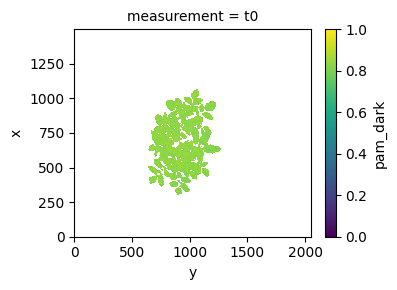

In [43]:
# Calculate and analyze PSII efficiency
if not ps.pam_dark is None:
  yii_global, yii_chart = pcv.analyze.yii(ps_da=ps.pam_dark, labeled_mask=mask, measurement_labels=["Fv/Fm"])
elif not ps.pam_light is None:
  yii_global, yii_chart = pcv.analyze.yii(ps_da=ps.pam_light, labeled_mask=mask, measurement_labels=["Fq'/Fm'"])
elif not ps.ojip_dark is None:
  #Extract FM data as numpy array
  yii_global, yii_chart = pcv.analyze.yii(ps_da=ps.ojip_dark, labeled_mask=mask, measurement_labels=["Fv/Fm"])

# yii is how plantcv calls the fv/fm or Fq'/Fm'.
stats = {'min_yii': round(float(yii_global.min().values),2), 'mean_yii': round(float(yii_global.mean().values),2), 'max_yii': round(float(yii_global.max().values),2)}
stats

<ipython-input-51-f41013e705cd>:15: RuntimeWarning: divide by zero encountered in divide
  FVFM = (FM - F0) / FM
<ipython-input-51-f41013e705cd>:15: RuntimeWarning: invalid value encountered in divide
  FVFM = (FM - F0) / FM


mean FVFM: 0.828813529283828


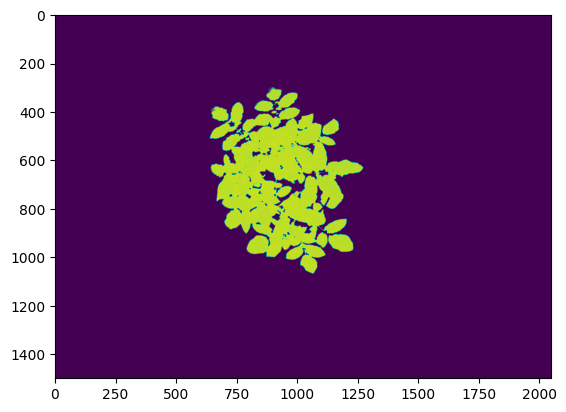

In [51]:
# Compute FV/FM by hand
if not ps.pam_dark is None:
  #Extract FM data as numpy array
  FM = ps.pam_dark.sel(frame_label='Fm').to_numpy()
  F0 = ps.pam_dark.sel(frame_label='F0').to_numpy()
elif not ps.pam_light is None:
  #Extract FMp data as numpy array
  FM = ps.pam_dark.sel(frame_label='Fmp').to_numpy()
  F0 = ps.pam_dark.sel(frame_label='Fp').to_numpy()
elif not ps.ojip_dark is None:
  #Extract FM data as numpy array
  FM = ps.ojip_dark.sel(frame_label='Fm').to_numpy()
  F0 = ps.ojip_dark.sel(frame_label='F0').to_numpy()

FVFM = (FM - F0) / FM
masked_FVFM = cv2.bitwise_and(FVFM, FVFM, mask=mask)
plt.imshow(masked_FVFM)
FVFM[np.isinf(FVFM)] = np.nan
mean_FVFM = np.nanmean(FVFM[mask > 0])
print(f"mean FVFM: {mean_FVFM}")

# Questions
- Can you think of more quality checks to perform on the data?
- Which other parameters can you compute from this data?

# Example to process an dataset
This notebook gives examples aof what can be done with plantcv using a single plant.
Once you hav found the parameters you want to analyse you might want to analyse all the data of an entire experiment. In this section an example workflow is given:

In [ ]:
# Preperation
from glob import glob
from pathlib import Path
from json import load
import pandas as pd
pcv.params.debug = "None"

In [ ]:
all_parameters_list = []
datafolder = "/content/drive/My Drive/P4P_workshop_data/Lucia"
# Loop over all plants
for filename in glob(datafolder + "/**/*.INF", recursive=True):
  # Load data
  print(f'analyzing: {filename}')
  a_ps = pcv.photosynthesis.read_cropreporter(filename=filename)

  # Load metadata
  path = Path(filename)
  metadata_filename = path.parent.parent.absolute().joinpath('metadata.json')
  with open(metadata_filename) as file:
      metadata = load(file)

  # Mask
  mask = pcv.threshold.otsu(gray_img=img_as_ubyte(ps.chlorophyll.sel(frame_label="Chl").data), object_type="light")

  # Correct wavelengths
  ps.spectral.wavelength_dict = {475: 0.0, 540: 1.0, 550: 2.0, 640: 3.0, 710: 4.0, 770: 5.0}

  # NDVI
  ndvi_img = pcv.spectral_index.ndvi(hsi=ps.spectral, distance=30).array_data
  masked_ndvi_img = cv2.bitwise_and(ndvi_img, ndvi_img, mask=mask)
  mean_ndvi = round(np.nanmean(ndvi_img[mask > 0]),2)
  # Optional add other traits
  #....

  #....
  # Create dictionary with plant parameters
  plant_parameters = {'filename': filename,
                      'Datetime': metadata['Datetime'],
                      'ExperimentId': metadata['ExperimentId'],
                      'TreatmentId': metadata['TreatmentId'],
                      'PlantId': metadata['PlantId'],
                      'CameraHeight': metadata['Extra']['Height'],
                      'ConfigFile': metadata['Extra']['Height'],
                      'mean_ndvi': mean_ndvi
                      }
  all_parameters_list.append(plant_parameters)

In [ ]:
# Combine all dictionaries into one table
parameter_table = pd.DataFrame(all_parameters_list)
parameter_table

In [ ]:
# Save table as csv
parameter_table.to_csv('extracted_cropreporter_traits.csv', index = False)

# Bonus: Plotting
Comparing data is always nicer with some graphs, while this can be done in Excel. Tools like plotly enable you to make fancy looking interactive graphs.
For more information see: https://plotly.com/graphing-libraries/

In [ ]:
import plotly.graph_objects as go
import plotly.express as px
import pandas as pd
from plotly.subplots import make_subplots

In [ ]:
# Load a prepared dataset
croprep_df = pd.read_csv(datafolder + '/cropreporter_traits.csv')
# Convert datetime
croprep_df['Datetime'] = pd.to_datetime(croprep_df['Datetime'], infer_datetime_format=True)

croprep_df.head(5)

In [ ]:
fig = make_subplots()

for plantid in croprep_df['PlantId'].unique():
  plant_df = croprep_df.loc[croprep_df['PlantId'] == plantid]
  fig.add_trace(go.Scatter(x = plant_df['Datetime'], y=plant_df['MeanEgreen'], mode = 'lines', name = plantid))

# Set titel
fig.update_layout(title_text="Mean Egreen of all plants",
                   xaxis_title="Datetime",
                  yaxis_title="Egreen",
                  legend_title="Plants",)
# Interactivity
fig.update_layout(
    hovermode="x unified", #show trace line
    xaxis=dict( # Buttons at the top
    rangeselector=dict(
        buttons=list([
            dict(count=1, label="day", step="day",stepmode="backward"),
            dict(step="all")
        ])
    ),
    rangeslider = dict(visible=True), type="date")
)
fig.show()

In [ ]:
# Save the graph to disk
fig.write_html('climate plot.html')

# Bonus two: analyse directly on Azure
On a regular basis NPEC is contacted by researchers which simply don't have enough diskspace to download their entire dataset.
As NPEC we run into the same issue, therefore we run the analysis directly on the data in Azure, without downloading it first!

We had to slightly modify plantcv to work in this way, the modified git is here:
https://github.com/wurDevTim/plantcv/tree/azure
And can be installed by chaning

```
!pip install plantcv
```
to:


```
!pip install git+https://github.com/wurDevTim/plantcv.git@azure
```



In [ ]:
!pip install azure-storage-blob
# In this notebook we already have plantcv, this must be uninstalled first
!pip uninstall plantcv
!pip install git+https://github.com/wurDevTim/plantcv.git@azure

In [ ]:
# Imports
import pandas as pd
from json import loads
from plantcv import plantcv as pcv
from azure.storage.blob import ContainerClient

It's not advised to share access keys in a git, not even read only only keys to a test environment like we are using here. Therefore please ask Tim for a test key if want to try this!

In this example we use the SAS URL (Shared access token) as used in the Azure storage explorer.

The used Permissions are Read & List


In [ ]:
sas_url = "<paste sas url token here>"
container_client = ContainerClient.from_container_url(sas_url)

This version of pandas needs the exact file locations, therefore we have to do a little magic:

In [ ]:
# Retrieve a list with all cropreporter files in the storage account
blob_list = container_client.list_blobs()
filenames = []
for blob in blob_list:
  filename = blob.name
  # Only cropreporter data
  if filename.split('/',1)[0] == "CropReporter":
    filenames.append(filename)

In [ ]:
# Switch to pandas for more advanced sorting options
filenames_df = pd.DataFrame({'filename':filenames})
#Split into folder & filename:
filenames_df[['folder','data','file']] = filenames_df['filename'].str.rsplit("/", n=2, expand=True)

# Modify the foldernames of the metadata so the foldernames match the names of the files
# The data is in a subfolder.
filenames_df.loc[filenames_df['file'] == 'metadata.json', 'folder'] = filenames_df.loc[filenames_df['file'] == 'metadata.json', 'folder'] + '/' + filenames_df.loc[filenames_df['file'] == 'metadata.json', 'data']

filenames_df

In [ ]:
# Loop over all folders and extract the files:
for foldername in filenames_df['folder'].unique():
  # One meassurement
  kwargs = {}
  for idx, row in filenames_df.loc[filenames_df['folder'] == foldername].iterrows():
    if row['file'] == 'metadata.json':
      metadata_file_path = row['filename']
    elif 'HDR' in row['file']:
      kwargs['hdr_blob_name'] = row['filename']
    elif 'CHL' in row['file']:
      kwargs['chl_blob_name'] = row['filename']
    elif 'CLR' in row['file']:
      kwargs["clr_blob_name"] = row['filename']
    elif 'SPC' in row['file']:
      kwargs["spc_blob_name"] = row['filename']
    elif 'PMD' in row['file']:
      kwargs["pmd_blob_name"] = row['filename']
    elif 'PML' in row['file']:
      kwargs["pml_blob_name"] = row['filename']

  # Load the metadata json
  blob_client = container_client.get_blob_client(metadata_file_path)
  stream = blob_client.download_blob(encoding='UTF-8')
  metadata_dict = loads(stream.readall())
  # Load plant into plantcv
  ps = pcv.photosynthesis.read_cropreporter(container_client, kwargs)
  #-----------------------------------
  # Process the data, forexample using one of the methods shown above
  #-----------------------------------